<a href="https://colab.research.google.com/github/IMOKURI/atmacup11/blob/main/atmacup11_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook ...

- Competition site: [atma cup #11](https://www.guruguru.science/competitions/17/)
- [WandB training logs](https://wandb.ai/imokuri/atma11)







## Prepare for Colab

In [1]:
!nvidia-smi

Wed Jul 14 05:01:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/gdrive')

        !cp /gdrive/MyDrive/Datasets/dataset_atmaCup11.zip .

        !unzip dataset_atmaCup11.zip
        !mkdir -p photos
        !unzip photos.zip -d photos
        !mv 'atmaCup#11_sample_submission.csv' atmaCup11_sample_submission.csv

    # for StratifiedGroupKFold
    !pip uninstall -y scikit-learn
    !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    !pip install -q wandb
    !pip install -Uq timm
    !pip install -Uq albumentations

    !touch init.txt

Already initialized.


## Library

In [3]:
import glob
import json
import math
import os
import random
import time
import warnings
from contextlib import contextmanager

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from albumentations.pytorch import ToTensorV2
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [4]:
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!wandb login

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [7]:
wandb_job_type = ""
wandb_notes = ""
wandb_tags = []

## Load Data

In [8]:
DATA_DIR = "../input/atmacup11/"
BASE_DIR = "../input/atmacup11/photos/"
OUTPUT_DIR = "./"

if 'google.colab' in sys.modules:
    DATA_DIR = "./"
    BASE_DIR = "./photos/"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
paths = [path for path in glob.glob(BASE_DIR + "*.jpg")]
print(len(paths))

9856


In [10]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "atmaCup11_sample_submission.csv")
material = pd.read_csv(DATA_DIR + "materials.csv")
technique = pd.read_csv(DATA_DIR + "techniques.csv")

In [11]:
# https://www.guruguru.science/competitions/17/discussions/000d76a9-fc4b-443e-95f2-5c066c0f3108/
train["sorting_date_target"] = train["sorting_date"] / 100.0 - 15.51

In [12]:
for ds in [train, test, sub]:
    print(f"=" * 80)
    ds.info()
    display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   object_id            3937 non-null   object 
 1   sorting_date         3937 non-null   int64  
 2   art_series_id        3937 non-null   object 
 3   target               3937 non-null   int64  
 4   sorting_date_target  3937 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 153.9+ KB


,object_id,sorting_date,art_series_id,target,sorting_date_target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1,0.80
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3,3.49
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3,2.83
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2,1.92
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3,3.34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5919 entries, 0 to 5918
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   object_id  5919 non-null   object
dtypes: object(1)
memory usage: 46.4+ KB


,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5919 entries, 0 to 5918
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  5919 non-null   int64
dtypes: int64(1)
memory usage: 46.4 KB


,target
0,3
1,1
2,3
3,3
4,0


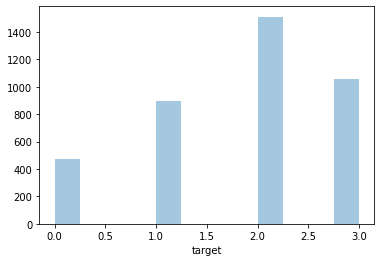

In [13]:
sns.distplot(train["target"], kde=False)

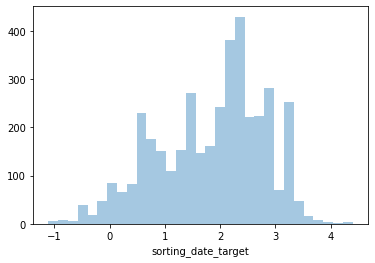

In [14]:
sns.distplot(train["sorting_date_target"], kde=False)

In [15]:
train["art_series_id"].value_counts()

607c22f5e66e8d50a298    9
6fb734ceff36fe2184b5    7
78db88c5ca6d7f6f4ac6    6
600db76c79a01bc40eb1    4
f8b88aff7f66a106ba3f    4
                       ..
7d0123151e8e118c8d11    1
1cdf3fe614a2d6a8a037    1
573b1f045aacd7d3eed1    1
d0bbaebd86f8a86fd12f    1
e0f24ebaede72e67021c    1
Name: art_series_id, Length: 3784, dtype: int64

## Config

In [16]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "atma11"
    print_freq = 50

    train = True
    validate = False
    inference = False

    debug = False
    multi_gpu = False
    apex = False


In [17]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

In [18]:
if Config.apex:
    from apex import amp

In [19]:
config_defaults = {
    "seed": 440,
    "size": 256,
    "n_class": 1,
    "n_fold": 5,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "num_workers": 4,
    "batch_size": 16,
    "epochs": 20,
    "scheduler": "CosineAnnealingWarmRestarts",
    "criterion": "RMSELoss",
    "lr": 1e-3,
    "min_lr": 1e-4,
    "weight_decay": 1e-6,
    "model_name": "efficientnet_b1",
    "inference_runs": [
        "i44ysfyk", # 28
    ],
    "no_aug": False,
}


In [20]:
if config_defaults["scheduler"] == "CosineAnnealingWarmRestarts":
    config_defaults["T_0"] = config_defaults["epochs"]

elif config_defaults["scheduler"] == "CosineAnnealingLR":
    config_defaults["T_max"] = config_defaults["epochs"]

elif config_defaults["scheduler"] == "ReduceLROnPlateau":
    config_defaults["factor"] = 0.2
    config_defaults["patience"] = 4
    config_defaults["eps"] = 1e-6


In [21]:
if Config.debug:
    config_defaults["epochs"] = 1

In [22]:
if Config.debug:
    wandb.init(project=Config.wandb_project, config=config_defaults, mode="disabled")
else:
    wandb.init(project=Config.wandb_project, config=config_defaults, notes=wandb_notes, tags=wandb_tags, job_type=wandb_job_type, save_code=True)

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [23]:
config = wandb.config

## Load Models

In [24]:
if Config.validate or Config.inference:
    api = wandb.Api()
    inference_models = []

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            for file in run.files():
                file.download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        inference_model = {}
        inference_model["run_id"] = run_id
        inference_model["model_name"] = run.config["model_name"]
        
        for fold in range(config.n_fold):
            model_preds = torch.load(f"{run_id}/{inference_model['model_name']}_fold{fold}_best.pth")
            inference_model[f"state_fold{fold}"] = model_preds["model"]
            inference_model[f"preds_fold{fold}"] = model_preds["preds"]

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["object_id", "preds"]]
        oof.columns = ["object_id", f"preds{n}"]
        train = pd.merge(train, oof, on="object_id", )

        inference_models.append(inference_model)
    
    print(train.columns)
    print({m['run_id']: m['model_name'] for m in inference_models})

In [25]:
if Config.debug:
    train = train.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    test = test.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    sub = sub.sample(n=1000, random_state=config.seed).reset_index(drop=True)

## Utils

In [26]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)


## CV Split

In [27]:
folds = train.copy()
Fold = StratifiedGroupKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["target"], folds["art_series_id"])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(np.uint8)
print(folds.groupby(["fold", "target"]).size())


fold  target
0     0          93
      1         211
      2         274
      3         212
1     0          89
      1         196
      2         301
      3         202
2     0          96
      1         151
      2         320
      3         217
3     0          96
      1         176
      2         296
      3         215
4     0         101
      1         162
      2         320
      3         209
dtype: int64


## Dataset

In [28]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["object_id"].values
        self.labels = df["sorting_date_target"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{BASE_DIR}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).float()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["object_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{BASE_DIR}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image


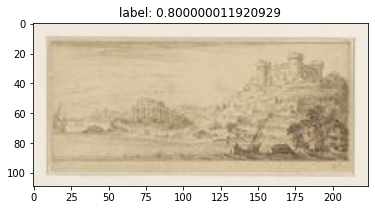

In [29]:
# Test

train_ds = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_ds[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()


## Transform

In [30]:
def get_transforms(*, data):

    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size, scale=(0.5, 1.0)),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                A.CoarseDropout(p=0.5),
                A.Cutout(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "weak_train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size, scale=(0.5, 1.0)),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                # A.CoarseDropout(p=0.5),
                # A.Cutout(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                # A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )


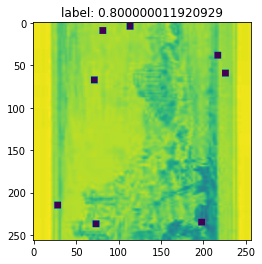

In [31]:
# Test

train_ds = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_ds[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()


## Model

In [32]:
class Atma11Net(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "res" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("vit_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)
            
        elif "nfnet" in model_name:
            n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(n_features, config.n_class)

    def forward(self, x):
        x = self.model(x).view(x.size(0))
        return x


In [33]:
# Test

model = Atma11Net(model_name=config.model_name, pretrained=False)
print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break


Atma11Net(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, 

## Loss

In [34]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss


## Scoring

In [35]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [36]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["target"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    # wandb.log({"fold": fold, "CV": score})
    if fold == config.n_fold:
        wandb.run.summary[f"CV"] = score
    else:
        wandb.run.summary[f"CV_fold{fold}"] = score


## Helper functions

In [37]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [38]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        y_preds = model(images.float())

        loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps
        if Config.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.val:.4f}({losses.avg:.4f}) "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_last_lr()[0]:.6f}  "
            )

    return losses.avg

In [39]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record accuracy
        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.val:.4f}({losses.avg:.4f}) "
            )
    predictions = np.clip(np.concatenate(preds), 0, 3)
    return losses.avg, predictions

In [40]:
def inference(test_loader):
    predictions = []
    for model_item in inference_models:
        for fold in range(config.n_fold):
            LOGGER.info(f"========== ID: {model_item['run_id']} model: {model_item['model_name']} fold: {fold} inference ==========")
            model = Atma11Net(model_item["model_name"])
            model.to(device)
            model.load_state_dict(model_item[f"state_fold{fold}"])
            model.eval()
            preds = []
            for i, (images) in enumerate(test_loader):
                images = images.to(device)
                with torch.no_grad():
                    y_preds = model(images)
                # avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
                preds.append(y_preds.to("cpu").numpy())
            preds = np.concatenate(preds)
            predictions.append(preds)
    predictions = np.clip(np.mean(predictions, axis=0), 0, 3)
    return predictions


## Train loop

In [41]:
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_weak_aug = TrainDataset(train_folds, transform=get_transforms(data="weak_train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_weak_aug = DataLoader(
        train_dataset_weak_aug,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if config.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=config.factor, patience=config.patience, verbose=True, eps=config.eps
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        return scheduler

    # ====================================================
    # Model & Optimizer
    # ====================================================
    model = Atma11Net(config.model_name)
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not Config.apex and Config.multi_gpu:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # Apex
    # ====================================================
    if Config.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "RMSELoss":
            criterion = RMSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = np.inf
    best_loss = np.inf

    # if not Config.multi_gpu:
    #     wandb.watch(model, log_freq=Config.print_freq)

    for epoch in range(config.epochs):

        start_time = time.time()

        # train
        if config.no_aug or epoch <= 1 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device)
        elif epoch >= config.epochs - 5:
            avg_loss = train_fn(train_loader_weak_aug, model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["target"].values

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/val_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        if score < best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth"
            )
            wandb.save(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

        # if epoch == config.epochs - 1:
        #     LOGGER.info(f"Epoch {epoch+1} - Save final model")
        #     torch.save(
        #         {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_final.pth"
        #     )

    check_point = torch.load(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"]  # .argmax(1)

    return valid_folds

## Main


In [42]:
def main():
    if Config.train:
        oof_df = pd.DataFrame()
        for fold in range(config.n_fold):
            _oof_df = train_loop(folds, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")
        
    if Config.validate:
        probs = []

        for n, model_item in enumerate(inference_models):
            probs.append(train[f"preds{n}"].values)
        preds = np.mean(probs, axis=0)

        train["preds"] = np.clip(preds, 0, 3)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(train)
        
        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    if Config.inference:
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
        )
        predictions = inference(test_loader)

        # submission
        sub["target"] = predictions  # .argmax(1)
        sub.to_csv(OUTPUT_DIR + "submission.csv", index=False)
        wandb.save(OUTPUT_DIR + "submission.csv")

In [ ]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/196] Elapsed 0m 0s (remain 2m 35s) Loss: 2.4446(2.4446) Grad: 5.9277 LR: 0.001000  
Epoch: [1][50/196] Elapsed 0m 9s (remain 0m 26s) Loss: 1.1404(1.1507) Grad: 15.0279 LR: 0.001000  
Epoch: [1][100/196] Elapsed 0m 18s (remain 0m 16s) Loss: 1.0366(1.0567) Grad: 3.4354 LR: 0.001000  
Epoch: [1][150/196] Elapsed 0m 26s (remain 0m 7s) Loss: 1.0110(1.0203) Grad: 4.7367 LR: 0.001000  
Epoch: [1][195/196] Elapsed 0m 34s (remain 0m 0s) Loss: 1.2469(1.0020) Grad: 2.7433 LR: 0.001000  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8320(0.8320) 


Epoch 1 - avg_train_loss: 1.0020  avg_val_loss: 1.2140  time: 37s
Epoch 1 - Score: 0.95167736016768
Epoch 1 - Save Best Score: 0.9517 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6830(1.2140) 
Epoch: [2][0/196] Elapsed 0m 0s (remain 2m 5s) Loss: 1.2004(1.2004) Grad: 3.2817 LR: 0.000994  
Epoch: [2][50/196] Elapsed 0m 9s (remain 0m 26s) Loss: 1.0333(0.9049) Grad: 3.8817 LR: 0.000994  
Epoch: [2][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9600(0.9129) Grad: 3.9863 LR: 0.000994  
Epoch: [2][150/196] Elapsed 0m 26s (remain 0m 8s) Loss: 0.7872(0.9174) Grad: 2.8461 LR: 0.000994  
Epoch: [2][195/196] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7635(0.9099) Grad: 2.2341 LR: 0.000994  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 0.9600(0.9600) 


Epoch 2 - avg_train_loss: 0.9099  avg_val_loss: 1.1128  time: 38s
Epoch 2 - Score: 0.9591812527276571


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7060(1.1128) 
Epoch: [3][0/196] Elapsed 0m 0s (remain 2m 11s) Loss: 1.0779(1.0779) Grad: 1.9837 LR: 0.000978  
Epoch: [3][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.9715(0.9543) Grad: 2.1206 LR: 0.000978  
Epoch: [3][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7944(0.9664) Grad: 3.1822 LR: 0.000978  
Epoch: [3][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0998(0.9458) Grad: 2.6891 LR: 0.000978  
Epoch: [3][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.8800(0.9442) Grad: 3.6125 LR: 0.000978  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.9668(0.9668) 


Epoch 3 - avg_train_loss: 0.9442  avg_val_loss: 1.0779  time: 38s
Epoch 3 - Score: 1.0080594134950875


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9713(1.0779) 
Epoch: [4][0/196] Elapsed 0m 0s (remain 2m 20s) Loss: 1.0395(1.0395) Grad: 2.2341 LR: 0.000951  
Epoch: [4][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.6794(0.9576) Grad: 2.1413 LR: 0.000951  
Epoch: [4][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9625(0.9458) Grad: 2.3716 LR: 0.000951  
Epoch: [4][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7996(0.9415) Grad: 3.3645 LR: 0.000951  
Epoch: [4][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.8654(0.9293) Grad: 3.0192 LR: 0.000951  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.9249(0.9249) 


Epoch 4 - avg_train_loss: 0.9293  avg_val_loss: 0.9202  time: 39s
Epoch 4 - Score: 0.9196973738362109
Epoch 4 - Save Best Score: 0.9197 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9254(0.9202) 
Epoch: [5][0/196] Elapsed 0m 0s (remain 2m 26s) Loss: 1.1795(1.1795) Grad: 3.1253 LR: 0.000914  
Epoch: [5][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.6075(0.8853) Grad: 2.3793 LR: 0.000914  
Epoch: [5][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7600(0.8979) Grad: 1.1559 LR: 0.000914  
Epoch: [5][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8983(0.9070) Grad: 2.8513 LR: 0.000914  
Epoch: [5][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.9700(0.9087) Grad: 1.6892 LR: 0.000914  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7601(0.7601) 


Epoch 5 - avg_train_loss: 0.9087  avg_val_loss: 0.8908  time: 39s
Epoch 5 - Score: 0.8942100470751656
Epoch 5 - Save Best Score: 0.8942 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0973(0.8908) 
Epoch: [6][0/196] Elapsed 0m 0s (remain 2m 29s) Loss: 0.8757(0.8757) Grad: 3.5139 LR: 0.000868  
Epoch: [6][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8526(0.8971) Grad: 2.6360 LR: 0.000868  
Epoch: [6][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8253(0.9033) Grad: 1.3858 LR: 0.000868  
Epoch: [6][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.6581(0.9104) Grad: 1.2955 LR: 0.000868  
Epoch: [6][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.6964(0.9073) Grad: 3.0936 LR: 0.000868  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.9115(0.9115) 


Epoch 6 - avg_train_loss: 0.9073  avg_val_loss: 0.9460  time: 39s
Epoch 6 - Score: 0.9602393577194063


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0263(0.9460) 
Epoch: [7][0/196] Elapsed 0m 0s (remain 2m 23s) Loss: 1.3697(1.3697) Grad: 1.4559 LR: 0.000815  
Epoch: [7][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0998(0.8958) Grad: 1.9855 LR: 0.000815  
Epoch: [7][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8277(0.9017) Grad: 2.5933 LR: 0.000815  
Epoch: [7][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7408(0.9008) Grad: 1.8349 LR: 0.000815  
Epoch: [7][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 1.0581(0.9013) Grad: 3.0266 LR: 0.000815  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 0.7089(0.7089) 


Epoch 7 - avg_train_loss: 0.9013  avg_val_loss: 0.8822  time: 39s
Epoch 7 - Score: 0.8942870954602065


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9433(0.8822) 
Epoch: [8][0/196] Elapsed 0m 0s (remain 2m 8s) Loss: 0.9682(0.9682) Grad: 2.0334 LR: 0.000754  
Epoch: [8][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7644(0.8797) Grad: 2.2908 LR: 0.000754  
Epoch: [8][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 1.3261(0.8876) Grad: 1.4894 LR: 0.000754  
Epoch: [8][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7247(0.8967) Grad: 2.1642 LR: 0.000754  
Epoch: [8][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 1.0418(0.8931) Grad: 1.6036 LR: 0.000754  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7505(0.7505) 


Epoch 8 - avg_train_loss: 0.8931  avg_val_loss: 0.8755  time: 39s
Epoch 8 - Score: 0.8864358417660134
Epoch 8 - Save Best Score: 0.8864 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0596(0.8755) 
Epoch: [9][0/196] Elapsed 0m 0s (remain 2m 33s) Loss: 1.0050(1.0050) Grad: 3.0168 LR: 0.000689  
Epoch: [9][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.9631(0.9100) Grad: 1.1180 LR: 0.000689  
Epoch: [9][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8443(0.9046) Grad: 2.0623 LR: 0.000689  
Epoch: [9][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8829(0.9018) Grad: 3.3459 LR: 0.000689  
Epoch: [9][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.8954(0.8964) Grad: 2.6109 LR: 0.000689  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7849(0.7849) 


Epoch 9 - avg_train_loss: 0.8964  avg_val_loss: 0.8823  time: 39s
Epoch 9 - Score: 0.8843107554133497
Epoch 9 - Save Best Score: 0.8843 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0106(0.8823) 
Epoch: [10][0/196] Elapsed 0m 0s (remain 2m 33s) Loss: 0.7710(0.7710) Grad: 1.0557 LR: 0.000620  
Epoch: [10][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0899(0.8692) Grad: 2.1931 LR: 0.000620  
Epoch: [10][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7906(0.8632) Grad: 2.2703 LR: 0.000620  
Epoch: [10][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.9645(0.8733) Grad: 3.0521 LR: 0.000620  
Epoch: [10][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6759(0.8760) Grad: 3.3735 LR: 0.000620  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7286(0.7286) 


Epoch 10 - avg_train_loss: 0.8760  avg_val_loss: 0.8670  time: 39s
Epoch 10 - Score: 0.8833987345034429
Epoch 10 - Save Best Score: 0.8834 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1017(0.8670) 
Epoch: [11][0/196] Elapsed 0m 0s (remain 2m 40s) Loss: 0.8787(0.8787) Grad: 1.8008 LR: 0.000550  
Epoch: [11][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8704(0.8968) Grad: 2.1564 LR: 0.000550  
Epoch: [11][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8201(0.8940) Grad: 2.5395 LR: 0.000550  
Epoch: [11][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0315(0.8824) Grad: 2.9196 LR: 0.000550  
Epoch: [11][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.6450(0.8739) Grad: 2.0800 LR: 0.000550  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 14s) Loss: 0.7581(0.7581) 


Epoch 11 - avg_train_loss: 0.8739  avg_val_loss: 0.8764  time: 39s
Epoch 11 - Score: 0.8910628511824159


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1437(0.8764) 
Epoch: [12][0/196] Elapsed 0m 0s (remain 2m 3s) Loss: 1.0743(1.0743) Grad: 2.7321 LR: 0.000480  
Epoch: [12][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 1.1307(0.8469) Grad: 1.9271 LR: 0.000480  
Epoch: [12][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9660(0.8711) Grad: 2.3181 LR: 0.000480  
Epoch: [12][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8881(0.8661) Grad: 1.6818 LR: 0.000480  
Epoch: [12][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 1.3247(0.8646) Grad: 2.6381 LR: 0.000480  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 0.7616(0.7616) 


Epoch 12 - avg_train_loss: 0.8646  avg_val_loss: 0.8425  time: 39s
Epoch 12 - Score: 0.851785606924334
Epoch 12 - Save Best Score: 0.8518 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1442(0.8425) 
Epoch: [13][0/196] Elapsed 0m 0s (remain 2m 39s) Loss: 0.8022(0.8022) Grad: 3.7901 LR: 0.000411  
Epoch: [13][50/196] Elapsed 0m 9s (remain 0m 28s) Loss: 0.6880(0.8634) Grad: 2.6131 LR: 0.000411  
Epoch: [13][100/196] Elapsed 0m 19s (remain 0m 17s) Loss: 1.0483(0.8629) Grad: 1.4685 LR: 0.000411  
Epoch: [13][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7690(0.8692) Grad: 1.3666 LR: 0.000411  
Epoch: [13][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9222(0.8603) Grad: 1.7453 LR: 0.000411  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.7410(0.7410) 


Epoch 13 - avg_train_loss: 0.8603  avg_val_loss: 0.8388  time: 39s
Epoch 13 - Score: 0.8449340286504881
Epoch 13 - Save Best Score: 0.8449 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0152(0.8388) 
Epoch: [14][0/196] Elapsed 0m 0s (remain 2m 25s) Loss: 0.7101(0.7101) Grad: 1.3921 LR: 0.000346  
Epoch: [14][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8849(0.8521) Grad: 2.9008 LR: 0.000346  
Epoch: [14][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7108(0.8520) Grad: 1.9420 LR: 0.000346  
Epoch: [14][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8797(0.8471) Grad: 3.1128 LR: 0.000346  
Epoch: [14][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.7936(0.8502) Grad: 1.3233 LR: 0.000346  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7115(0.7115) 


Epoch 14 - avg_train_loss: 0.8502  avg_val_loss: 0.8526  time: 39s
Epoch 14 - Score: 0.863650078786341


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1707(0.8526) 
Epoch: [15][0/196] Elapsed 0m 0s (remain 2m 1s) Loss: 0.7057(0.7057) Grad: 1.5221 LR: 0.000285  
Epoch: [15][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.9601(0.8288) Grad: 2.6494 LR: 0.000285  
Epoch: [15][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9023(0.8416) Grad: 2.5753 LR: 0.000285  
Epoch: [15][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 1.1254(0.8510) Grad: 1.2821 LR: 0.000285  
Epoch: [15][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 1.0541(0.8451) Grad: 1.5072 LR: 0.000285  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7842(0.7842) 


Epoch 15 - avg_train_loss: 0.8451  avg_val_loss: 0.8598  time: 39s
Epoch 15 - Score: 0.8657387456455092


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0415(0.8598) 
Epoch: [16][0/196] Elapsed 0m 0s (remain 2m 3s) Loss: 0.8508(0.8508) Grad: 1.8663 LR: 0.000232  
Epoch: [16][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8306(0.8273) Grad: 1.9030 LR: 0.000232  
Epoch: [16][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.4417(0.8226) Grad: 1.6186 LR: 0.000232  
Epoch: [16][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0148(0.8197) Grad: 3.4245 LR: 0.000232  
Epoch: [16][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 1.1295(0.8276) Grad: 1.7659 LR: 0.000232  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6957(0.6957) 


Epoch 16 - avg_train_loss: 0.8276  avg_val_loss: 0.8271  time: 39s
Epoch 16 - Score: 0.8365165179669153
Epoch 16 - Save Best Score: 0.8365 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1008(0.8271) 
Epoch: [17][0/196] Elapsed 0m 0s (remain 2m 22s) Loss: 1.1961(1.1961) Grad: 2.0395 LR: 0.000186  
Epoch: [17][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0469(0.8376) Grad: 2.6583 LR: 0.000186  
Epoch: [17][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9043(0.8244) Grad: 1.6235 LR: 0.000186  
Epoch: [17][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.5448(0.8137) Grad: 1.4735 LR: 0.000186  
Epoch: [17][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.8385(0.8216) Grad: 2.5287 LR: 0.000186  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 0.7036(0.7036) 


Epoch 17 - avg_train_loss: 0.8216  avg_val_loss: 0.8347  time: 39s
Epoch 17 - Score: 0.8385983440501673


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1343(0.8347) 
Epoch: [18][0/196] Elapsed 0m 0s (remain 2m 1s) Loss: 0.8558(0.8558) Grad: 2.4350 LR: 0.000149  
Epoch: [18][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7193(0.8084) Grad: 1.9350 LR: 0.000149  
Epoch: [18][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7096(0.8122) Grad: 1.7801 LR: 0.000149  
Epoch: [18][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.9539(0.8105) Grad: 2.6756 LR: 0.000149  
Epoch: [18][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.8232(0.8052) Grad: 1.5764 LR: 0.000149  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6726(0.6726) 


Epoch 18 - avg_train_loss: 0.8052  avg_val_loss: 0.8345  time: 39s
Epoch 18 - Score: 0.8506956183096636


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2174(0.8345) 
Epoch: [19][0/196] Elapsed 0m 0s (remain 1m 49s) Loss: 0.5161(0.5161) Grad: 2.9714 LR: 0.000122  
Epoch: [19][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.6562(0.7867) Grad: 2.4725 LR: 0.000122  
Epoch: [19][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7528(0.7978) Grad: 1.5665 LR: 0.000122  
Epoch: [19][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8245(0.7942) Grad: 1.5760 LR: 0.000122  
Epoch: [19][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 1.0098(0.7869) Grad: 2.0653 LR: 0.000122  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6584(0.6584) 


Epoch 19 - avg_train_loss: 0.7869  avg_val_loss: 0.8086  time: 39s
Epoch 19 - Score: 0.8284681188850543
Epoch 19 - Save Best Score: 0.8285 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1667(0.8086) 
Epoch: [20][0/196] Elapsed 0m 0s (remain 2m 2s) Loss: 0.8506(0.8506) Grad: 3.6109 LR: 0.000106  
Epoch: [20][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7783(0.7628) Grad: 1.5683 LR: 0.000106  
Epoch: [20][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.5891(0.7575) Grad: 2.3852 LR: 0.000106  
Epoch: [20][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8890(0.7496) Grad: 2.2184 LR: 0.000106  
Epoch: [20][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 1.0676(0.7536) Grad: 2.8966 LR: 0.000106  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 19s) Loss: 0.5904(0.5904) 


Epoch 20 - avg_train_loss: 0.7536  avg_val_loss: 0.8092  time: 39s
Epoch 20 - Score: 0.837558186707557
========== fold: 0 result ==========
Score: 0.82847


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2310(0.8092) 


========== fold: 1 training ==========


Epoch: [1][0/196] Elapsed 0m 1s (remain 3m 25s) Loss: 1.8157(1.8157) Grad: 6.5848 LR: 0.001000  
Epoch: [1][50/196] Elapsed 0m 10s (remain 0m 28s) Loss: 1.3067(1.1286) Grad: 9.2359 LR: 0.001000  
Epoch: [1][100/196] Elapsed 0m 19s (remain 0m 18s) Loss: 0.9862(1.0417) Grad: 3.7951 LR: 0.001000  
Epoch: [1][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 1.1689(1.0167) Grad: 3.7233 LR: 0.001000  
Epoch: [1][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9786(0.9975) Grad: 2.4739 LR: 0.001000  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 18s) Loss: 0.7348(0.7348) 


Epoch 1 - avg_train_loss: 0.9975  avg_val_loss: 0.8650  time: 39s
Epoch 1 - Score: 0.8750002081366544
Epoch 1 - Save Best Score: 0.8750 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9958(0.8650) 
Epoch: [2][0/196] Elapsed 0m 0s (remain 2m 22s) Loss: 1.0025(1.0025) Grad: 2.3276 LR: 0.000994  
Epoch: [2][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8060(0.9223) Grad: 3.6249 LR: 0.000994  
Epoch: [2][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9145(0.9181) Grad: 3.8282 LR: 0.000994  
Epoch: [2][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0768(0.9051) Grad: 3.6106 LR: 0.000994  
Epoch: [2][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9697(0.9033) Grad: 4.6066 LR: 0.000994  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 22s) Loss: 0.8602(0.8602) 


Epoch 2 - avg_train_loss: 0.9033  avg_val_loss: 0.8969  time: 39s
Epoch 2 - Score: 0.8960401615883323


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8449(0.8969) 
Epoch: [3][0/196] Elapsed 0m 0s (remain 2m 19s) Loss: 0.9775(0.9775) Grad: 4.2150 LR: 0.000978  
Epoch: [3][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.9073(0.9335) Grad: 4.6088 LR: 0.000978  
Epoch: [3][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8132(0.9445) Grad: 4.9878 LR: 0.000978  
Epoch: [3][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.8886(0.9300) Grad: 1.8506 LR: 0.000978  
Epoch: [3][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9496(0.9326) Grad: 1.8882 LR: 0.000978  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7403(0.7403) 


Epoch 3 - avg_train_loss: 0.9326  avg_val_loss: 0.8571  time: 39s
Epoch 3 - Score: 0.8736780310022685
Epoch 3 - Save Best Score: 0.8737 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0938(0.8571) 
Epoch: [4][0/196] Elapsed 0m 0s (remain 2m 36s) Loss: 1.0584(1.0584) Grad: 2.0463 LR: 0.000951  
Epoch: [4][50/196] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8688(0.9170) Grad: 2.4033 LR: 0.000951  
Epoch: [4][100/196] Elapsed 0m 19s (remain 0m 17s) Loss: 0.8108(0.9247) Grad: 1.2670 LR: 0.000951  
Epoch: [4][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 1.1508(0.9167) Grad: 2.3075 LR: 0.000951  
Epoch: [4][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9554(0.9207) Grad: 3.7234 LR: 0.000951  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.8079(0.8079) 


Epoch 4 - avg_train_loss: 0.9207  avg_val_loss: 0.8552  time: 39s
Epoch 4 - Score: 0.8719569512942718
Epoch 4 - Save Best Score: 0.8720 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7609(0.8552) 
Epoch: [5][0/196] Elapsed 0m 0s (remain 2m 24s) Loss: 0.9895(0.9895) Grad: 1.0584 LR: 0.000914  
Epoch: [5][50/196] Elapsed 0m 9s (remain 0m 28s) Loss: 0.7232(0.9061) Grad: 1.2427 LR: 0.000914  
Epoch: [5][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9358(0.9056) Grad: 0.9228 LR: 0.000914  
Epoch: [5][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.6268(0.9099) Grad: 2.5022 LR: 0.000914  
Epoch: [5][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7299(0.9125) Grad: 1.4184 LR: 0.000914  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7691(0.7691) 


Epoch 5 - avg_train_loss: 0.9125  avg_val_loss: 0.8532  time: 39s
Epoch 5 - Score: 0.892285620759791


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9230(0.8532) 
Epoch: [6][0/196] Elapsed 0m 0s (remain 2m 21s) Loss: 0.9752(0.9752) Grad: 2.0604 LR: 0.000868  
Epoch: [6][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.9516(0.9084) Grad: 1.8389 LR: 0.000868  
Epoch: [6][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8695(0.8954) Grad: 2.0098 LR: 0.000868  
Epoch: [6][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 1.0444(0.9015) Grad: 2.8588 LR: 0.000868  
Epoch: [6][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7802(0.9060) Grad: 0.8608 LR: 0.000868  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7147(0.7147) 


Epoch 6 - avg_train_loss: 0.9060  avg_val_loss: 0.8476  time: 39s
Epoch 6 - Score: 0.8835033931169416


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9713(0.8476) 
Epoch: [7][0/196] Elapsed 0m 0s (remain 2m 27s) Loss: 1.1603(1.1603) Grad: 3.1463 LR: 0.000815  
Epoch: [7][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 1.1905(0.9421) Grad: 1.2002 LR: 0.000815  
Epoch: [7][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.6848(0.9179) Grad: 2.0141 LR: 0.000815  
Epoch: [7][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7321(0.9076) Grad: 3.4771 LR: 0.000815  
Epoch: [7][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 1.0373(0.8989) Grad: 1.7954 LR: 0.000815  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7634(0.7634) 


Epoch 7 - avg_train_loss: 0.8989  avg_val_loss: 0.8208  time: 39s
Epoch 7 - Score: 0.8587405021937288
Epoch 7 - Save Best Score: 0.8587 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0357(0.8208) 
Epoch: [8][0/196] Elapsed 0m 0s (remain 2m 42s) Loss: 0.6780(0.6780) Grad: 0.9321 LR: 0.000754  
Epoch: [8][50/196] Elapsed 0m 9s (remain 0m 28s) Loss: 0.7942(0.8891) Grad: 1.8012 LR: 0.000754  
Epoch: [8][100/196] Elapsed 0m 19s (remain 0m 17s) Loss: 1.1125(0.8868) Grad: 1.7920 LR: 0.000754  
Epoch: [8][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7891(0.8959) Grad: 1.1774 LR: 0.000754  
Epoch: [8][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8003(0.8925) Grad: 2.3982 LR: 0.000754  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7220(0.7220) 


Epoch 8 - avg_train_loss: 0.8925  avg_val_loss: 0.8248  time: 39s
Epoch 8 - Score: 0.8512214686001628
Epoch 8 - Save Best Score: 0.8512 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8783(0.8248) 
Epoch: [9][0/196] Elapsed 0m 0s (remain 2m 40s) Loss: 0.7569(0.7569) Grad: 1.3742 LR: 0.000689  
Epoch: [9][50/196] Elapsed 0m 9s (remain 0m 28s) Loss: 1.0897(0.8974) Grad: 1.6390 LR: 0.000689  
Epoch: [9][100/196] Elapsed 0m 19s (remain 0m 17s) Loss: 0.9795(0.9166) Grad: 0.7744 LR: 0.000689  
Epoch: [9][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 1.0847(0.8999) Grad: 1.8796 LR: 0.000689  
Epoch: [9][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9041(0.8954) Grad: 1.6815 LR: 0.000689  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7277(0.7277) 


Epoch 9 - avg_train_loss: 0.8954  avg_val_loss: 0.8017  time: 39s
Epoch 9 - Score: 0.8417713359910534
Epoch 9 - Save Best Score: 0.8418 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9167(0.8017) 
Epoch: [10][0/196] Elapsed 0m 0s (remain 2m 47s) Loss: 0.7609(0.7609) Grad: 2.0741 LR: 0.000620  
Epoch: [10][50/196] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8269(0.8852) Grad: 2.0922 LR: 0.000620  
Epoch: [10][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9369(0.8749) Grad: 2.3821 LR: 0.000620  
Epoch: [10][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.9179(0.8732) Grad: 1.9018 LR: 0.000620  
Epoch: [10][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9685(0.8828) Grad: 1.2307 LR: 0.000620  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6744(0.6744) 


Epoch 10 - avg_train_loss: 0.8828  avg_val_loss: 0.8057  time: 39s
Epoch 10 - Score: 0.8524863890678472


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0589(0.8057) 
Epoch: [11][0/196] Elapsed 0m 0s (remain 2m 11s) Loss: 0.7687(0.7687) Grad: 1.1442 LR: 0.000550  
Epoch: [11][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.6912(0.8979) Grad: 1.0830 LR: 0.000550  
Epoch: [11][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.6930(0.8859) Grad: 2.1106 LR: 0.000550  
Epoch: [11][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.6112(0.8881) Grad: 2.9619 LR: 0.000550  
Epoch: [11][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6850(0.8836) Grad: 1.9104 LR: 0.000550  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8183(0.8183) 


Epoch 11 - avg_train_loss: 0.8836  avg_val_loss: 0.8261  time: 39s
Epoch 11 - Score: 0.8501590056636802


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0941(0.8261) 
Epoch: [12][0/196] Elapsed 0m 0s (remain 1m 57s) Loss: 0.6874(0.6874) Grad: 1.7784 LR: 0.000480  
Epoch: [12][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7586(0.8638) Grad: 1.1338 LR: 0.000480  
Epoch: [12][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0486(0.8850) Grad: 3.1112 LR: 0.000480  
Epoch: [12][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.5615(0.8762) Grad: 1.8942 LR: 0.000480  
Epoch: [12][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6832(0.8724) Grad: 3.2278 LR: 0.000480  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7912(0.7912) 


Epoch 12 - avg_train_loss: 0.8724  avg_val_loss: 0.8243  time: 39s
Epoch 12 - Score: 0.8449196822915198


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0217(0.8243) 
Epoch: [13][0/196] Elapsed 0m 0s (remain 2m 10s) Loss: 0.8309(0.8309) Grad: 1.8373 LR: 0.000411  
Epoch: [13][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8124(0.8937) Grad: 1.6550 LR: 0.000411  
Epoch: [13][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0451(0.8898) Grad: 1.8376 LR: 0.000411  
Epoch: [13][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0021(0.8739) Grad: 2.2219 LR: 0.000411  
Epoch: [13][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8771(0.8618) Grad: 2.1704 LR: 0.000411  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7235(0.7235) 


Epoch 13 - avg_train_loss: 0.8618  avg_val_loss: 0.7913  time: 39s
Epoch 13 - Score: 0.8299489929620703
Epoch 13 - Save Best Score: 0.8299 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0375(0.7913) 
Epoch: [14][0/196] Elapsed 0m 0s (remain 2m 32s) Loss: 0.6655(0.6655) Grad: 1.2506 LR: 0.000346  
Epoch: [14][50/196] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8882(0.8260) Grad: 1.4046 LR: 0.000346  
Epoch: [14][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8005(0.8436) Grad: 1.5502 LR: 0.000346  
Epoch: [14][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7868(0.8453) Grad: 1.5009 LR: 0.000346  
Epoch: [14][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8874(0.8509) Grad: 1.7065 LR: 0.000346  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.8786(0.8786) 


Epoch 14 - avg_train_loss: 0.8509  avg_val_loss: 0.8648  time: 39s
Epoch 14 - Score: 0.8865607521099834


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2166(0.8648) 
Epoch: [15][0/196] Elapsed 0m 0s (remain 2m 19s) Loss: 0.8083(0.8083) Grad: 0.9266 LR: 0.000285  
Epoch: [15][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7333(0.8560) Grad: 1.5920 LR: 0.000285  
Epoch: [15][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9362(0.8747) Grad: 1.7494 LR: 0.000285  
Epoch: [15][150/196] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7512(0.8619) Grad: 1.8453 LR: 0.000285  
Epoch: [15][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7852(0.8628) Grad: 1.6398 LR: 0.000285  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.8426(0.8426) 


Epoch 15 - avg_train_loss: 0.8628  avg_val_loss: 0.8217  time: 39s
Epoch 15 - Score: 0.864739105134259


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0443(0.8217) 
Epoch: [16][0/196] Elapsed 0m 0s (remain 2m 3s) Loss: 0.7234(0.7234) Grad: 2.3305 LR: 0.000232  
Epoch: [16][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.5919(0.8347) Grad: 1.6001 LR: 0.000232  
Epoch: [16][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7289(0.8214) Grad: 2.4350 LR: 0.000232  
Epoch: [16][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7643(0.8247) Grad: 4.2610 LR: 0.000232  
Epoch: [16][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.7135(0.8388) Grad: 2.7097 LR: 0.000232  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8020(0.8020) 


Epoch 16 - avg_train_loss: 0.8388  avg_val_loss: 0.7736  time: 39s
Epoch 16 - Score: 0.8138458677657543
Epoch 16 - Save Best Score: 0.8138 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0587(0.7736) 
Epoch: [17][0/196] Elapsed 0m 0s (remain 2m 22s) Loss: 0.7007(0.7007) Grad: 1.4147 LR: 0.000186  
Epoch: [17][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7510(0.8190) Grad: 1.3816 LR: 0.000186  
Epoch: [17][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7565(0.8171) Grad: 2.5528 LR: 0.000186  
Epoch: [17][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7487(0.8180) Grad: 2.4177 LR: 0.000186  
Epoch: [17][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9412(0.8300) Grad: 5.9133 LR: 0.000186  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 17s) Loss: 0.8518(0.8518) 


Epoch 17 - avg_train_loss: 0.8300  avg_val_loss: 0.8134  time: 39s
Epoch 17 - Score: 0.8493794818865056


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0417(0.8134) 
Epoch: [18][0/196] Elapsed 0m 0s (remain 2m 2s) Loss: 0.5517(0.5517) Grad: 1.4609 LR: 0.000149  
Epoch: [18][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7508(0.8190) Grad: 2.4338 LR: 0.000149  
Epoch: [18][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9288(0.8041) Grad: 2.4082 LR: 0.000149  
Epoch: [18][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7739(0.8186) Grad: 4.0676 LR: 0.000149  
Epoch: [18][195/196] Elapsed 0m 35s (remain 0m 0s) Loss: 0.9160(0.8293) Grad: 2.1491 LR: 0.000149  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.8058(0.8058) 


Epoch 18 - avg_train_loss: 0.8293  avg_val_loss: 0.7802  time: 39s
Epoch 18 - Score: 0.8149671062392256


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0117(0.7802) 
Epoch: [19][0/196] Elapsed 0m 0s (remain 1m 59s) Loss: 0.7159(0.7159) Grad: 2.0585 LR: 0.000122  
Epoch: [19][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.5921(0.7640) Grad: 1.3978 LR: 0.000122  
Epoch: [19][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7407(0.7763) Grad: 2.8635 LR: 0.000122  
Epoch: [19][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.9468(0.7859) Grad: 3.4316 LR: 0.000122  
Epoch: [19][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9121(0.7900) Grad: 3.1992 LR: 0.000122  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7345(0.7345) 


Epoch 19 - avg_train_loss: 0.7900  avg_val_loss: 0.7535  time: 39s
Epoch 19 - Score: 0.7989013820792982
Epoch 19 - Save Best Score: 0.7989 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0266(0.7535) 
Epoch: [20][0/196] Elapsed 0m 0s (remain 2m 16s) Loss: 0.8692(0.8692) Grad: 1.6678 LR: 0.000106  
Epoch: [20][50/196] Elapsed 0m 9s (remain 0m 27s) Loss: 0.6872(0.7889) Grad: 4.0069 LR: 0.000106  
Epoch: [20][100/196] Elapsed 0m 18s (remain 0m 17s) Loss: 0.6664(0.7739) Grad: 1.8754 LR: 0.000106  
Epoch: [20][150/196] Elapsed 0m 27s (remain 0m 8s) Loss: 0.6768(0.7680) Grad: 3.4996 LR: 0.000106  
Epoch: [20][195/196] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5739(0.7672) Grad: 2.5271 LR: 0.000106  
EVAL: [0/50] Elapsed 0m 0s (remain 0m 22s) Loss: 0.7245(0.7245) 


Epoch 20 - avg_train_loss: 0.7672  avg_val_loss: 0.7442  time: 39s
Epoch 20 - Score: 0.7877959023912514
Epoch 20 - Save Best Score: 0.7878 Model


EVAL: [49/50] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0272(0.7442) 


========== fold: 1 result ==========
Score: 0.78780
========== fold: 2 training ==========


Epoch: [1][0/197] Elapsed 0m 0s (remain 1m 55s) Loss: 2.0906(2.0906) Grad: 9.1091 LR: 0.001000  
Epoch: [1][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0947(1.1967) Grad: 5.8492 LR: 0.001000  
Epoch: [1][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 1.2821(1.0842) Grad: 5.1541 LR: 0.001000  
Epoch: [1][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0389(1.0491) Grad: 3.9083 LR: 0.001000  
Epoch: [1][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6262(1.0171) Grad: 4.2956 LR: 0.001000  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.8512(0.8512) 


Epoch 1 - avg_train_loss: 1.0171  avg_val_loss: 1.6322  time: 39s
Epoch 1 - Score: 0.9485063631715872
Epoch 1 - Save Best Score: 0.9485 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 2.3558(1.6322) 
Epoch: [2][0/197] Elapsed 0m 0s (remain 2m 4s) Loss: 1.0318(1.0318) Grad: 4.9671 LR: 0.000994  
Epoch: [2][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 1.3720(0.9000) Grad: 5.6560 LR: 0.000994  
Epoch: [2][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7255(0.9081) Grad: 2.8307 LR: 0.000994  
Epoch: [2][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.6607(0.8976) Grad: 4.2438 LR: 0.000994  
Epoch: [2][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8532(0.8893) Grad: 4.6380 LR: 0.000994  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.5596(0.5596) 


Epoch 2 - avg_train_loss: 0.8893  avg_val_loss: 0.9995  time: 39s
Epoch 2 - Score: 0.883304420557173
Epoch 2 - Save Best Score: 0.8833 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9580(0.9995) 
Epoch: [3][0/197] Elapsed 0m 0s (remain 2m 41s) Loss: 1.1529(1.1529) Grad: 2.7542 LR: 0.000978  
Epoch: [3][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.9972(0.9334) Grad: 1.4611 LR: 0.000978  
Epoch: [3][100/197] Elapsed 0m 19s (remain 0m 18s) Loss: 1.0732(0.9297) Grad: 3.5789 LR: 0.000978  
Epoch: [3][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.8085(0.9194) Grad: 2.4496 LR: 0.000978  
Epoch: [3][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 1.1349(0.9308) Grad: 1.7542 LR: 0.000978  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7415(0.7415) 


Epoch 3 - avg_train_loss: 0.9308  avg_val_loss: 0.8831  time: 39s
Epoch 3 - Score: 0.9083019149314439


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0213(0.8831) 
Epoch: [4][0/197] Elapsed 0m 0s (remain 2m 24s) Loss: 0.9647(0.9647) Grad: 3.7404 LR: 0.000951  
Epoch: [4][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.9695(0.9531) Grad: 2.5668 LR: 0.000951  
Epoch: [4][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 1.0856(0.9455) Grad: 1.6850 LR: 0.000951  
Epoch: [4][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.8076(0.9295) Grad: 0.8137 LR: 0.000951  
Epoch: [4][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8274(0.9292) Grad: 1.0627 LR: 0.000951  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7284(0.7284) 


Epoch 4 - avg_train_loss: 0.9292  avg_val_loss: 0.8505  time: 39s
Epoch 4 - Score: 0.8890563078622098


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8723(0.8505) 
Epoch: [5][0/197] Elapsed 0m 0s (remain 1m 58s) Loss: 0.9298(0.9298) Grad: 3.4407 LR: 0.000914  
Epoch: [5][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0961(0.9268) Grad: 1.7012 LR: 0.000914  
Epoch: [5][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7722(0.9183) Grad: 1.6248 LR: 0.000914  
Epoch: [5][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.9952(0.9196) Grad: 2.4305 LR: 0.000914  
Epoch: [5][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8894(0.9128) Grad: 3.2500 LR: 0.000914  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7649(0.7649) 


Epoch 5 - avg_train_loss: 0.9128  avg_val_loss: 0.8338  time: 39s
Epoch 5 - Score: 0.8833884042566589


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9666(0.8338) 
Epoch: [6][0/197] Elapsed 0m 0s (remain 2m 9s) Loss: 1.1845(1.1845) Grad: 3.3290 LR: 0.000868  
Epoch: [6][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.9907(0.9005) Grad: 1.0606 LR: 0.000868  
Epoch: [6][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0578(0.9189) Grad: 2.7938 LR: 0.000868  
Epoch: [6][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8557(0.9119) Grad: 2.5723 LR: 0.000868  
Epoch: [6][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9664(0.9086) Grad: 1.3306 LR: 0.000868  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0190(1.0190) 


Epoch 6 - avg_train_loss: 0.9086  avg_val_loss: 0.9553  time: 39s
Epoch 6 - Score: 0.963692538548883


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9777(0.9553) 
Epoch: [7][0/197] Elapsed 0m 0s (remain 2m 18s) Loss: 1.0786(1.0786) Grad: 2.0995 LR: 0.000815  
Epoch: [7][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8965(0.9579) Grad: 1.6719 LR: 0.000815  
Epoch: [7][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7809(0.9198) Grad: 0.8136 LR: 0.000815  
Epoch: [7][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.9231(0.9055) Grad: 2.2897 LR: 0.000815  
Epoch: [7][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8368(0.9033) Grad: 2.7821 LR: 0.000815  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8788(0.8788) 


Epoch 7 - avg_train_loss: 0.9033  avg_val_loss: 0.8715  time: 39s
Epoch 7 - Score: 0.8983387031158754


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8925(0.8715) 
Epoch: [8][0/197] Elapsed 0m 0s (remain 2m 19s) Loss: 0.9378(0.9378) Grad: 1.0590 LR: 0.000754  
Epoch: [8][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8085(0.8667) Grad: 1.6793 LR: 0.000754  
Epoch: [8][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9759(0.8839) Grad: 3.2514 LR: 0.000754  
Epoch: [8][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7257(0.8828) Grad: 3.6565 LR: 0.000754  
Epoch: [8][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 1.0092(0.8921) Grad: 2.0259 LR: 0.000754  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8467(0.8467) 


Epoch 8 - avg_train_loss: 0.8921  avg_val_loss: 0.8316  time: 39s
Epoch 8 - Score: 0.8684381324159361
Epoch 8 - Save Best Score: 0.8684 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9570(0.8316) 
Epoch: [9][0/197] Elapsed 0m 0s (remain 2m 40s) Loss: 0.9062(0.9062) Grad: 1.2316 LR: 0.000689  
Epoch: [9][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 1.0386(0.8804) Grad: 2.1848 LR: 0.000689  
Epoch: [9][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 0.7114(0.8775) Grad: 2.3981 LR: 0.000689  
Epoch: [9][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.8767(0.8754) Grad: 1.1566 LR: 0.000689  
Epoch: [9][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7907(0.8833) Grad: 2.3150 LR: 0.000689  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 17s) Loss: 0.8233(0.8233) 


Epoch 9 - avg_train_loss: 0.8833  avg_val_loss: 0.8918  time: 39s
Epoch 9 - Score: 0.9341461376163365


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0175(0.8918) 
Epoch: [10][0/197] Elapsed 0m 0s (remain 2m 23s) Loss: 0.9774(0.9774) Grad: 2.3282 LR: 0.000620  
Epoch: [10][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.9943(0.8833) Grad: 1.3829 LR: 0.000620  
Epoch: [10][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0196(0.9062) Grad: 0.9855 LR: 0.000620  
Epoch: [10][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8619(0.8888) Grad: 1.4574 LR: 0.000620  
Epoch: [10][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9376(0.8858) Grad: 1.6754 LR: 0.000620  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.8700(0.8700) 


Epoch 10 - avg_train_loss: 0.8858  avg_val_loss: 0.8387  time: 39s
Epoch 10 - Score: 0.8676912882906059
Epoch 10 - Save Best Score: 0.8677 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9932(0.8387) 
Epoch: [11][0/197] Elapsed 0m 0s (remain 2m 23s) Loss: 0.9035(0.9035) Grad: 1.8814 LR: 0.000550  
Epoch: [11][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 1.1622(0.8784) Grad: 3.3476 LR: 0.000550  
Epoch: [11][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8145(0.8905) Grad: 1.7693 LR: 0.000550  
Epoch: [11][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7426(0.8858) Grad: 2.0755 LR: 0.000550  
Epoch: [11][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7962(0.8804) Grad: 1.5488 LR: 0.000550  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7774(0.7774) 


Epoch 11 - avg_train_loss: 0.8804  avg_val_loss: 0.8268  time: 39s
Epoch 11 - Score: 0.8698840039698533


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9886(0.8268) 
Epoch: [12][0/197] Elapsed 0m 0s (remain 2m 22s) Loss: 0.7603(0.7603) Grad: 1.5401 LR: 0.000480  
Epoch: [12][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 1.0658(0.9274) Grad: 1.3487 LR: 0.000480  
Epoch: [12][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8989(0.8874) Grad: 2.7618 LR: 0.000480  
Epoch: [12][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0597(0.8778) Grad: 1.4045 LR: 0.000480  
Epoch: [12][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8390(0.8765) Grad: 1.2374 LR: 0.000480  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7651(0.7651) 


Epoch 12 - avg_train_loss: 0.8765  avg_val_loss: 0.8099  time: 39s
Epoch 12 - Score: 0.859474343986701
Epoch 12 - Save Best Score: 0.8595 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8532(0.8099) 
Epoch: [13][0/197] Elapsed 0m 0s (remain 2m 36s) Loss: 0.9313(0.9313) Grad: 2.8534 LR: 0.000411  
Epoch: [13][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 1.0632(0.8888) Grad: 2.1915 LR: 0.000411  
Epoch: [13][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 0.7991(0.8740) Grad: 2.1719 LR: 0.000411  
Epoch: [13][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7805(0.8728) Grad: 1.3817 LR: 0.000411  
Epoch: [13][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8824(0.8778) Grad: 3.0849 LR: 0.000411  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.8219(0.8219) 


Epoch 13 - avg_train_loss: 0.8778  avg_val_loss: 0.8175  time: 39s
Epoch 13 - Score: 0.8499602276727973
Epoch 13 - Save Best Score: 0.8500 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8759(0.8175) 
Epoch: [14][0/197] Elapsed 0m 0s (remain 2m 48s) Loss: 0.9431(0.9431) Grad: 1.2872 LR: 0.000346  
Epoch: [14][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.9500(0.8416) Grad: 1.4076 LR: 0.000346  
Epoch: [14][100/197] Elapsed 0m 19s (remain 0m 18s) Loss: 1.0003(0.8632) Grad: 1.6429 LR: 0.000346  
Epoch: [14][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.9396(0.8670) Grad: 1.5650 LR: 0.000346  
Epoch: [14][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8611(0.8639) Grad: 1.2811 LR: 0.000346  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7908(0.7908) 


Epoch 14 - avg_train_loss: 0.8639  avg_val_loss: 0.7997  time: 39s
Epoch 14 - Score: 0.8435707185601163
Epoch 14 - Save Best Score: 0.8436 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8991(0.7997) 
Epoch: [15][0/197] Elapsed 0m 0s (remain 2m 38s) Loss: 1.1384(1.1384) Grad: 1.8821 LR: 0.000285  
Epoch: [15][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8994(0.8520) Grad: 2.2280 LR: 0.000285  
Epoch: [15][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 0.9109(0.8504) Grad: 2.4154 LR: 0.000285  
Epoch: [15][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.9299(0.8571) Grad: 2.3136 LR: 0.000285  
Epoch: [15][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7109(0.8619) Grad: 2.3083 LR: 0.000285  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.7360(0.7360) 


Epoch 15 - avg_train_loss: 0.8619  avg_val_loss: 0.8284  time: 39s
Epoch 15 - Score: 0.8641185113995602


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8585(0.8284) 
Epoch: [16][0/197] Elapsed 0m 0s (remain 2m 3s) Loss: 0.7627(0.7627) Grad: 3.3513 LR: 0.000232  
Epoch: [16][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.6579(0.8474) Grad: 4.4264 LR: 0.000232  
Epoch: [16][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7785(0.8409) Grad: 1.9344 LR: 0.000232  
Epoch: [16][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.5826(0.8388) Grad: 1.8508 LR: 0.000232  
Epoch: [16][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6092(0.8458) Grad: 2.5183 LR: 0.000232  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.8478(0.8478) 


Epoch 16 - avg_train_loss: 0.8458  avg_val_loss: 0.8356  time: 39s
Epoch 16 - Score: 0.8733731752465426


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0175(0.8356) 
Epoch: [17][0/197] Elapsed 0m 0s (remain 2m 1s) Loss: 0.8361(0.8361) Grad: 2.4387 LR: 0.000186  
Epoch: [17][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8507(0.8338) Grad: 2.2603 LR: 0.000186  
Epoch: [17][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8681(0.8365) Grad: 2.4061 LR: 0.000186  
Epoch: [17][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8039(0.8404) Grad: 2.0974 LR: 0.000186  
Epoch: [17][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 1.0270(0.8387) Grad: 1.9582 LR: 0.000186  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7820(0.7820) 


Epoch 17 - avg_train_loss: 0.8387  avg_val_loss: 0.7943  time: 39s
Epoch 17 - Score: 0.8375924282577383
Epoch 17 - Save Best Score: 0.8376 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8256(0.7943) 
Epoch: [18][0/197] Elapsed 0m 0s (remain 2m 25s) Loss: 0.8269(0.8269) Grad: 2.2706 LR: 0.000149  
Epoch: [18][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8592(0.8192) Grad: 2.4340 LR: 0.000149  
Epoch: [18][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.6127(0.8163) Grad: 2.8481 LR: 0.000149  
Epoch: [18][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.6666(0.8188) Grad: 1.2875 LR: 0.000149  
Epoch: [18][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8281(0.8218) Grad: 3.2392 LR: 0.000149  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.8272(0.8272) 


Epoch 18 - avg_train_loss: 0.8218  avg_val_loss: 0.8184  time: 39s
Epoch 18 - Score: 0.8465863515108777


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9874(0.8184) 
Epoch: [19][0/197] Elapsed 0m 0s (remain 1m 53s) Loss: 0.8248(0.8248) Grad: 2.6579 LR: 0.000122  
Epoch: [19][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.6928(0.8357) Grad: 2.3407 LR: 0.000122  
Epoch: [19][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8450(0.8155) Grad: 3.8753 LR: 0.000122  
Epoch: [19][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 1.2695(0.7988) Grad: 2.9898 LR: 0.000122  
Epoch: [19][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5691(0.8056) Grad: 2.1993 LR: 0.000122  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.7005(0.7005) 


Epoch 19 - avg_train_loss: 0.8056  avg_val_loss: 0.7622  time: 39s
Epoch 19 - Score: 0.8130990407119453
Epoch 19 - Save Best Score: 0.8131 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8921(0.7622) 
Epoch: [20][0/197] Elapsed 0m 0s (remain 2m 9s) Loss: 1.0651(1.0651) Grad: 2.3437 LR: 0.000106  
Epoch: [20][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.3907(0.7795) Grad: 3.5443 LR: 0.000106  
Epoch: [20][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7773(0.7788) Grad: 2.8359 LR: 0.000106  
Epoch: [20][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.9861(0.7841) Grad: 4.5429 LR: 0.000106  
Epoch: [20][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6814(0.7782) Grad: 3.0547 LR: 0.000106  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7379(0.7379) 


Epoch 20 - avg_train_loss: 0.7782  avg_val_loss: 0.7777  time: 39s
Epoch 20 - Score: 0.8248896644761486
========== fold: 2 result ==========


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9749(0.7777) 


Score: 0.81310
========== fold: 3 training ==========


Epoch: [1][0/197] Elapsed 0m 0s (remain 1m 52s) Loss: 2.0760(2.0760) Grad: 6.8373 LR: 0.001000  
Epoch: [1][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0974(1.1499) Grad: 5.5388 LR: 0.001000  
Epoch: [1][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9004(1.0627) Grad: 4.6172 LR: 0.001000  
Epoch: [1][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.4924(1.0170) Grad: 3.6337 LR: 0.001000  
Epoch: [1][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7038(0.9876) Grad: 4.5374 LR: 0.001000  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.5752(0.5752) 


Epoch 1 - avg_train_loss: 0.9876  avg_val_loss: 1.9295  time: 39s
Epoch 1 - Score: 1.0226425693995636
Epoch 1 - Save Best Score: 1.0226 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1536(1.9295) 
Epoch: [2][0/197] Elapsed 0m 0s (remain 2m 8s) Loss: 0.9447(0.9447) Grad: 3.5067 LR: 0.000994  
Epoch: [2][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8799(0.8436) Grad: 4.5843 LR: 0.000994  
Epoch: [2][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9297(0.8787) Grad: 3.8385 LR: 0.000994  
Epoch: [2][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 1.0464(0.8881) Grad: 2.5898 LR: 0.000994  
Epoch: [2][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9562(0.8812) Grad: 7.5580 LR: 0.000994  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6724(0.6724) 


Epoch 2 - avg_train_loss: 0.8812  avg_val_loss: 1.0807  time: 39s
Epoch 2 - Score: 0.9849438519535308
Epoch 2 - Save Best Score: 0.9849 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0025(1.0807) 
Epoch: [3][0/197] Elapsed 0m 0s (remain 2m 33s) Loss: 0.7673(0.7673) Grad: 3.0678 LR: 0.000978  
Epoch: [3][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.6702(0.9804) Grad: 2.5049 LR: 0.000978  
Epoch: [3][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 0.6681(0.9527) Grad: 2.7541 LR: 0.000978  
Epoch: [3][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.9235(0.9548) Grad: 1.5407 LR: 0.000978  
Epoch: [3][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9382(0.9500) Grad: 3.8046 LR: 0.000978  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5116(0.5116) 


Epoch 3 - avg_train_loss: 0.9500  avg_val_loss: 0.8980  time: 39s
Epoch 3 - Score: 0.9108156107379647
Epoch 3 - Save Best Score: 0.9108 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9865(0.8980) 
Epoch: [4][0/197] Elapsed 0m 0s (remain 2m 49s) Loss: 0.7657(0.7657) Grad: 3.0329 LR: 0.000951  
Epoch: [4][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 1.1593(0.9231) Grad: 5.2415 LR: 0.000951  
Epoch: [4][100/197] Elapsed 0m 19s (remain 0m 18s) Loss: 0.8843(0.9107) Grad: 2.8700 LR: 0.000951  
Epoch: [4][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.8032(0.9190) Grad: 1.8896 LR: 0.000951  
Epoch: [4][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 1.0609(0.9232) Grad: 3.0249 LR: 0.000951  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.6545(0.6545) 


Epoch 4 - avg_train_loss: 0.9232  avg_val_loss: 0.8869  time: 39s
Epoch 4 - Score: 0.9250698691146892


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0613(0.8869) 
Epoch: [5][0/197] Elapsed 0m 0s (remain 2m 24s) Loss: 1.0138(1.0138) Grad: 3.5912 LR: 0.000914  
Epoch: [5][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.9062(0.9147) Grad: 2.5950 LR: 0.000914  
Epoch: [5][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0571(0.9098) Grad: 3.0928 LR: 0.000914  
Epoch: [5][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.9317(0.9084) Grad: 1.1046 LR: 0.000914  
Epoch: [5][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8198(0.9118) Grad: 2.9878 LR: 0.000914  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 22s) Loss: 0.6137(0.6137) 


Epoch 5 - avg_train_loss: 0.9118  avg_val_loss: 0.8780  time: 39s
Epoch 5 - Score: 0.9160412401742386


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0627(0.8780) 
Epoch: [6][0/197] Elapsed 0m 0s (remain 2m 17s) Loss: 1.0151(1.0151) Grad: 2.7339 LR: 0.000868  
Epoch: [6][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8751(0.9374) Grad: 2.9398 LR: 0.000868  
Epoch: [6][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0394(0.9112) Grad: 1.4419 LR: 0.000868  
Epoch: [6][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 1.4899(0.9189) Grad: 3.3150 LR: 0.000868  
Epoch: [6][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9505(0.9148) Grad: 2.2081 LR: 0.000868  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 18s) Loss: 0.7474(0.7474) 


Epoch 6 - avg_train_loss: 0.9148  avg_val_loss: 0.8648  time: 39s
Epoch 6 - Score: 0.8923722020249357
Epoch 6 - Save Best Score: 0.8924 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9981(0.8648) 
Epoch: [7][0/197] Elapsed 0m 0s (remain 2m 6s) Loss: 1.0930(1.0930) Grad: 0.8511 LR: 0.000815  
Epoch: [7][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.9936(0.8978) Grad: 2.1752 LR: 0.000815  
Epoch: [7][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7338(0.8950) Grad: 2.1530 LR: 0.000815  
Epoch: [7][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8050(0.9017) Grad: 1.3183 LR: 0.000815  
Epoch: [7][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7885(0.9016) Grad: 1.1122 LR: 0.000815  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7496(0.7496) 


Epoch 7 - avg_train_loss: 0.9016  avg_val_loss: 0.8831  time: 39s
Epoch 7 - Score: 0.9111815365438982


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9799(0.8831) 
Epoch: [8][0/197] Elapsed 0m 0s (remain 2m 21s) Loss: 1.0862(1.0862) Grad: 0.9891 LR: 0.000754  
Epoch: [8][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.7884(0.9050) Grad: 1.2353 LR: 0.000754  
Epoch: [8][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0575(0.9046) Grad: 1.4073 LR: 0.000754  
Epoch: [8][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7685(0.8995) Grad: 2.2687 LR: 0.000754  
Epoch: [8][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6966(0.8976) Grad: 3.4057 LR: 0.000754  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.6861(0.6861) 


Epoch 8 - avg_train_loss: 0.8976  avg_val_loss: 0.8527  time: 39s
Epoch 8 - Score: 0.8923827002029637


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9449(0.8527) 
Epoch: [9][0/197] Elapsed 0m 0s (remain 2m 24s) Loss: 0.7400(0.7400) Grad: 2.3341 LR: 0.000689  
Epoch: [9][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.7785(0.8754) Grad: 2.2896 LR: 0.000689  
Epoch: [9][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 0.9556(0.8776) Grad: 2.2300 LR: 0.000689  
Epoch: [9][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.8076(0.8906) Grad: 1.5538 LR: 0.000689  
Epoch: [9][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7797(0.8893) Grad: 4.4578 LR: 0.000689  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.7215(0.7215) 


Epoch 9 - avg_train_loss: 0.8893  avg_val_loss: 0.8502  time: 39s
Epoch 9 - Score: 0.8892490767296938
Epoch 9 - Save Best Score: 0.8892 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8955(0.8502) 
Epoch: [10][0/197] Elapsed 0m 0s (remain 2m 23s) Loss: 0.8315(0.8315) Grad: 1.9084 LR: 0.000620  
Epoch: [10][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 1.1527(0.8699) Grad: 1.9437 LR: 0.000620  
Epoch: [10][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 0.5778(0.8523) Grad: 0.8874 LR: 0.000620  
Epoch: [10][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7620(0.8714) Grad: 1.0957 LR: 0.000620  
Epoch: [10][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 1.1236(0.8786) Grad: 2.8322 LR: 0.000620  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.6599(0.6599) 


Epoch 10 - avg_train_loss: 0.8786  avg_val_loss: 0.8421  time: 39s
Epoch 10 - Score: 0.8784454975491387
Epoch 10 - Save Best Score: 0.8784 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9661(0.8421) 
Epoch: [11][0/197] Elapsed 0m 0s (remain 2m 41s) Loss: 1.0071(1.0071) Grad: 2.1449 LR: 0.000550  
Epoch: [11][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8952(0.8604) Grad: 1.1095 LR: 0.000550  
Epoch: [11][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 1.1580(0.8739) Grad: 1.8404 LR: 0.000550  
Epoch: [11][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.9887(0.8688) Grad: 2.7538 LR: 0.000550  
Epoch: [11][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9368(0.8701) Grad: 1.8919 LR: 0.000550  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 15s) Loss: 0.6785(0.6785) 


Epoch 11 - avg_train_loss: 0.8701  avg_val_loss: 0.8477  time: 39s
Epoch 11 - Score: 0.8777501397463829
Epoch 11 - Save Best Score: 0.8778 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9109(0.8477) 
Epoch: [12][0/197] Elapsed 0m 0s (remain 2m 37s) Loss: 0.8298(0.8298) Grad: 1.8770 LR: 0.000480  
Epoch: [12][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.7411(0.8480) Grad: 2.0297 LR: 0.000480  
Epoch: [12][100/197] Elapsed 0m 19s (remain 0m 18s) Loss: 0.7758(0.8623) Grad: 0.9954 LR: 0.000480  
Epoch: [12][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 1.1353(0.8745) Grad: 1.4778 LR: 0.000480  
Epoch: [12][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8798(0.8667) Grad: 1.4157 LR: 0.000480  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 19s) Loss: 0.6655(0.6655) 


Epoch 12 - avg_train_loss: 0.8667  avg_val_loss: 0.8170  time: 39s
Epoch 12 - Score: 0.8470698162866179
Epoch 12 - Save Best Score: 0.8471 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8677(0.8170) 
Epoch: [13][0/197] Elapsed 0m 0s (remain 2m 44s) Loss: 0.8848(0.8848) Grad: 2.7588 LR: 0.000411  
Epoch: [13][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.7901(0.8682) Grad: 2.1311 LR: 0.000411  
Epoch: [13][100/197] Elapsed 0m 18s (remain 0m 18s) Loss: 0.7569(0.8563) Grad: 3.0921 LR: 0.000411  
Epoch: [13][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7689(0.8477) Grad: 2.2893 LR: 0.000411  
Epoch: [13][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 1.1114(0.8524) Grad: 1.8186 LR: 0.000411  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7125(0.7125) 


Epoch 13 - avg_train_loss: 0.8524  avg_val_loss: 0.8693  time: 39s
Epoch 13 - Score: 0.9033289369925704


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0143(0.8693) 
Epoch: [14][0/197] Elapsed 0m 0s (remain 2m 32s) Loss: 0.6018(0.6018) Grad: 1.4019 LR: 0.000346  
Epoch: [14][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8055(0.8375) Grad: 1.1519 LR: 0.000346  
Epoch: [14][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7531(0.8362) Grad: 1.5380 LR: 0.000346  
Epoch: [14][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.7713(0.8571) Grad: 1.9561 LR: 0.000346  
Epoch: [14][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9990(0.8531) Grad: 2.0636 LR: 0.000346  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 20s) Loss: 0.5846(0.5846) 


Epoch 14 - avg_train_loss: 0.8531  avg_val_loss: 0.8294  time: 39s
Epoch 14 - Score: 0.8609078708914403


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8378(0.8294) 
Epoch: [15][0/197] Elapsed 0m 0s (remain 2m 23s) Loss: 0.8198(0.8198) Grad: 1.9610 LR: 0.000285  
Epoch: [15][50/197] Elapsed 0m 9s (remain 0m 28s) Loss: 0.8046(0.8426) Grad: 2.3697 LR: 0.000285  
Epoch: [15][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.9057(0.8403) Grad: 2.2710 LR: 0.000285  
Epoch: [15][150/197] Elapsed 0m 28s (remain 0m 8s) Loss: 0.6742(0.8421) Grad: 2.7173 LR: 0.000285  
Epoch: [15][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 1.0128(0.8554) Grad: 2.2665 LR: 0.000285  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 21s) Loss: 0.6292(0.6292) 


Epoch 15 - avg_train_loss: 0.8554  avg_val_loss: 0.8400  time: 39s
Epoch 15 - Score: 0.8741805611819681


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9353(0.8400) 
Epoch: [16][0/197] Elapsed 0m 0s (remain 2m 7s) Loss: 0.6573(0.6573) Grad: 1.6529 LR: 0.000232  
Epoch: [16][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0115(0.8043) Grad: 1.7386 LR: 0.000232  
Epoch: [16][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8217(0.8224) Grad: 2.1264 LR: 0.000232  
Epoch: [16][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7567(0.8366) Grad: 2.3677 LR: 0.000232  
Epoch: [16][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9074(0.8342) Grad: 2.8333 LR: 0.000232  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 19s) Loss: 0.6406(0.6406) 


Epoch 16 - avg_train_loss: 0.8342  avg_val_loss: 0.8283  time: 39s
Epoch 16 - Score: 0.8650121845488288


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8616(0.8283) 
Epoch: [17][0/197] Elapsed 0m 0s (remain 2m 13s) Loss: 0.7161(0.7161) Grad: 2.5272 LR: 0.000186  
Epoch: [17][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.7373(0.8504) Grad: 3.0566 LR: 0.000186  
Epoch: [17][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.7574(0.8334) Grad: 1.7119 LR: 0.000186  
Epoch: [17][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.8105(0.8316) Grad: 2.6993 LR: 0.000186  
Epoch: [17][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.8920(0.8275) Grad: 2.3178 LR: 0.000186  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7183(0.7183) 


Epoch 17 - avg_train_loss: 0.8275  avg_val_loss: 0.8279  time: 39s
Epoch 17 - Score: 0.8595098720658019


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9663(0.8279) 
Epoch: [18][0/197] Elapsed 0m 0s (remain 2m 5s) Loss: 0.4975(0.4975) Grad: 2.5279 LR: 0.000149  
Epoch: [18][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 1.1105(0.8386) Grad: 2.1623 LR: 0.000149  
Epoch: [18][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 0.8151(0.8367) Grad: 3.4693 LR: 0.000149  
Epoch: [18][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.7233(0.8210) Grad: 3.4110 LR: 0.000149  
Epoch: [18][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9480(0.8225) Grad: 1.9052 LR: 0.000149  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 23s) Loss: 0.6053(0.6053) 


Epoch 18 - avg_train_loss: 0.8225  avg_val_loss: 0.8044  time: 39s
Epoch 18 - Score: 0.8328689960274868
Epoch 18 - Save Best Score: 0.8329 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9077(0.8044) 
Epoch: [19][0/197] Elapsed 0m 0s (remain 2m 14s) Loss: 1.0271(1.0271) Grad: 2.7570 LR: 0.000122  
Epoch: [19][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 1.0120(0.8084) Grad: 2.4613 LR: 0.000122  
Epoch: [19][100/197] Elapsed 0m 18s (remain 0m 17s) Loss: 1.0354(0.7839) Grad: 1.9550 LR: 0.000122  
Epoch: [19][150/197] Elapsed 0m 27s (remain 0m 8s) Loss: 0.5157(0.7764) Grad: 2.2523 LR: 0.000122  
Epoch: [19][196/197] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5909(0.7806) Grad: 1.6895 LR: 0.000122  
EVAL: [0/49] Elapsed 0m 0s (remain 0m 14s) Loss: 0.5612(0.5612) 


Epoch 19 - avg_train_loss: 0.7806  avg_val_loss: 0.7847  time: 39s
Epoch 19 - Score: 0.8241420890697638
Epoch 19 - Save Best Score: 0.8241 Model


EVAL: [48/49] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9291(0.7847) 
Epoch: [20][0/197] Elapsed 0m 0s (remain 2m 9s) Loss: 0.7323(0.7323) Grad: 2.6197 LR: 0.000106  
Epoch: [20][50/197] Elapsed 0m 9s (remain 0m 27s) Loss: 0.8219(0.7295) Grad: 1.9538 LR: 0.000106  


## Public LB

In [2]:
RUN_ID = None
LB_SCORE = 0.7890

WANDB_ENTITY = "imokuri"
WANDB_PROJECT = "atma11"

In [3]:
if RUN_ID is not None and LB_SCORE is not None:
    import wandb
    api = wandb.Api()

    run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{RUN_ID}")
    run.summary["LB"] = LB_SCORE
    run.summary.update()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
